In [1]:
!pip install -U simpletransformers tqdm

     |████████████████████████████████| 80 kB 5.2 MB/s 
     |████████████████████████████████| 221 kB 17.7 MB/s 
     |████████████████████████████████| 184 kB 70.3 MB/s 
     |████████████████████████████████| 76 kB 5.6 MB/s 
     |████████████████████████████████| 179 kB 72.6 MB/s 
     |████████████████████████████████| 64 kB 3.9 MB/s 
     |████████████████████████████████| 124 kB 64.7 MB/s 
     |████████████████████████████████| 1.8 MB 55.2 MB/s 
     |████████████████████████████████| 264 kB 78.0 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 3.3 MB 53.2 MB/s 
     |████████████████████████████████| 1.2 MB 63.6 MB/s 
     |████████████████████████████████| 2.6 MB 57.6 MB/s 
     |████████████████████████████████| 8.0 MB 78.4 MB/s 
     |████████████████████████████████| 895 kB 56.7 MB/s 
     |████████████████████████████████| 636 kB 59.8 MB/s 
     |████████████████████████████████| 170 kB 75.9 MB/s 
     |████████████████

In [13]:
import pandas as pd
#tqdm.pandas()

In [14]:
df = pd.read_csv("dataset.csv")

# The column names have extra space in the csv file, so we remove it
df.columns = ['logMethod', 'logLevel', 'logVariables', 'logLine',
       'logLocationType', 'codeSnippet', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10']

# Drop unwanted columns
df = df.drop(['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'], axis=1)

# Fill Nan values with empty string and 0
df['logMethod'] = df['logMethod'].fillna("")
df['logVariables'] = df['logVariables'].fillna("")
df['logLine'] = df['logLine'].fillna(0)
df['logLocationType'] = df['logLocationType'].fillna("")
df['codeSnippet'] = df['codeSnippet'].fillna("")

# Still some Nan values, remove it
df = df.dropna() 

# Reset index of pandas df
df.reset_index(drop = True, inplace = True)

# Lets see some data
df.head()

logMethod logLevel  \
0  logger.info("Classpath: {}", System.getPropert...     info   
1  LOGGER.warn("Linux OS id [{}] is present in th...     warn   
2  LOGGER.warn("Attempt {}/{} to pull Docker base...     warn   
3  LOGGER.info("Task {} requires docker-compose b...     info   
4  LOGGER.error(String.join(System.lineSeparator(...    error   

                                        logVariables  logLine logLocationType  \
0  ["Classpath: {}", System.getProperty("java.cla...     63.0                   
1  ["Linux OS id [{}] is present in the Docker ex...    196.0          ifStmt   
2  ["Attempt {}/{} to pull Docker base image {} f...    154.0         forStmt   
3  ["Task {} requires docker-compose but it is un...    170.0          ifStmt   
4         [String.join(System.lineSeparator(), msg)]    163.0     forEachStmt   

                                         codeSnippet  
0                                                     
1  if (excluded) {\n    LOGGER.warn("Linux OS id ...  
2  for (int attempt = 1; attempt <= maxAttempts; ...  
3  if (isComposeAvailable == false) {\n    LOGGER...  
4  // Finally, print out (and fail) if we have an...

In [15]:
# We will classify logLevel. 
# Here is the count of different type of logLevel
df["logLevel"].value_counts()

info     4812
debug    2211
trace    1701
warn     1365
error    1057
Name: logLevel, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

# We will use "codeSnippet" as input to model.
# So, keep only "codeSnippet", "logLevel"
df_logs = df[["codeSnippet", "logLevel"]].copy()

# Bert model requires columns to be names as "text" and "label"
# So, we will rename them
df_logs.columns = ["text", "label"]

# Bert model requires numeric lables instead of strings like "info", "debug" ... etc.
# So, we manually defined numeric labels for each label(label means logLevel)
mapping = {"info" : 0, "debug" : 1, "trace" : 2, 'warn' : 3, 'error' : 4}

# We will convert the labels to numeric values
df_logs["label"] = df_logs["label"].replace(mapping) # Change the lables to numeric

# Train, val, test split
train_df, test_df = train_test_split(df_logs, 
                                     train_size = 0.85, 
                                     random_state = 50,
                                     stratify=df_logs['label'])

# Train, val, test split
train_df, val_df = train_test_split(train_df, 
                                     train_size = 0.85, 
                                     random_state = 50)

print("train_df shape : ", train_df.shape)
print("test_df shape : ", test_df.shape)
print("val_df shape : ", val_df.shape)
print()
print("Count of train_df labels : ")
print(train_df["label"].value_counts())
print()
print("Count of test_df labels : ")
print(test_df["label"].value_counts())
print()
print("Count of val_df labels : ")
print(val_df["label"].value_counts())

train_df shape :  (8052, 2)
test_df shape :  (1672, 2)
val_df shape :  (1422, 2)

Count of train_df labels : 
0    3487
1    1583
2    1218
3    1003
4     761
Name: label, dtype: int64

Count of test_df labels : 
0    722
1    332
2    255
3    205
4    158
Name: label, dtype: int64

Count of val_df labels : 
0    603
1    296
2    228
3    157
4    138
Name: label, dtype: int64


<AxesSubplot:>

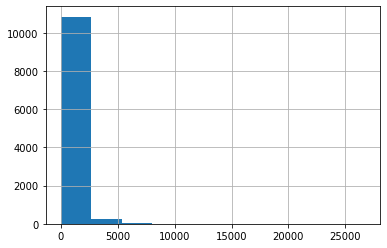

In [17]:
# Find max length of codesnippets
series_of_tweet_lengths = df_logs["text"].str.len()
series_of_tweet_lengths.hist()

In [18]:
# Compute class weight
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_df["label"]),
                                                 train_df["label"])
#classweights_dict = {}
#for i, j in enumerate(class_weights):
#    classweights_dict[i] = j

C:\Users\snbha\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=7412     3
7057     3
2459     0
3463     1
5382     0
        ..
1495     0
9484     3
1103     0
6467     2
10854    0
Name: label, Length: 8052, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [19]:
# The list of class weights for each class as below
list(class_weights)

[0.4618296529968454,
 1.017308907138345,
 1.3221674876847291,
 1.6055832502492522,
 2.1161629434954006]

In [20]:
# Bert training
import logging
from simpletransformers.classification import ClassificationModel
import logging
import wandb
import torch
from sklearn.metrics import f1_score, accuracy_score
import sklearn
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

# Check if CUDA avilable
cuda_available = torch.cuda.is_available()
print(cuda_available)



# Define weighted f1 score function
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='weighted')

# Define weighted recall score function
def macro_recall(labels, preds):
    return recall_score(labels, preds, average='weighted')

# # Define weighted precision score function
def get_precision(labels, preds):
    return precision_score(labels, preds, average='weighted')

False


# Use huggingface Transformer model called "huggingface/CodeBERTa-small-v1" for training and evaluation

In [21]:
# Optinal: If running this notebok on colab, remove the outputs and runs directory from previous runs. 
# !sudo rm -r /content/outputs /content/runs

### "CodeBERTa" is a "RoBERTa-like" model trained on the "CodeSearchNet dataset" from GitHub. <br/><br/>
---------
### Its trained on below programming languages: <br/>

### "go" <br/>
### "java" <br/>
### "javascript" <br/>
### "php" <br/>
### "python" <br/>
### "ruby" <br/><br/>
-----
### Link to [CodeBERTa-small-v1 Model on Huggingface](https://huggingface.co/huggingface/CodeBERTa-small-v1)    <br/><br/>

### Link to [CodeSearchNet dataset](https://github.blog/2019-09-26-introducing-the-codesearchnet-challenge/)    <br/><br/>
----
### The reason why I selected this model is because it is trained on the different types of programming languages. <br/>
### So, It is flexible enough to be used for any type of programming language to classify the "logLevel" <br/><br/>

### The original BERT model trained on plain english text like wikipedia, newsdataset, etc., but it wont work well for programming languages. <br/>
### "CodeBERTa" specifically trained on coding languages only, so it captures context of the programming language. <br/><br/>

### So, I just used the "huggingface/CodeBERTa-small-v1" model trained on the CodeSearchNet dataset, to finetune the model for the "logLevel" classification task.<br/><br/>
----
### Question : Why I think, its better than manually identfying features of the programming language? <br/>
### Answer : The problem with manually identifying features of the programming language is, you have to write rules for different programming languages. You have do it separately for java, for python, for PHP, for go.. like this for N number of different programming languages. <br/>
### This issue resolved by using a BERT like model which was trained on millions of lines of programming languages and diiferent languages. <br/>
### So, it generalizes well for any programming language. And can capture the context of code. <br/>
-----
### The "logLevel" classification task trained here on 8052 code chunks, validated of 1422 code chunks and tested on 1672 code chunks. <br/>
### If it would have been trained on at least some huge amount of code chunks(at least millions), The accuracy can be further improved.

## Define training arguments

In [23]:
# save_steps : Save a model checkpoint at every specified number of steps. Set to -1 to disable.
# save_eval_checkpoints : Save a model checkpoint for every evaluation performed. But we are not storing here.
# warmup_steps : Number of training steps where learning rate will “warm up”. Overrides warmup_ratio
# use_early_stopping : Use early stopping to stop training when early_stopping_metric doesn’t improve (based on early_stopping_patience, and early_stopping_delta)
# early_stopping_delta : The improvement over best_eval_loss necessary to count as a better checkpoint.
# early_stopping_metric : The metric that should be used with early stopping. (Should be computed during eval_during_training).
# early_stopping_metric_minimize : Whether early_stopping_metric should be minimized (or maximized).
# early_stopping_patience : Terminate training after this many evaluations without an improvement in the evaluation metric greater then early_stopping_delta.
# evaluate_during_training_steps : Perform evaluation at every specified number of steps. A checkpoint model and the evaluation results will be saved.
# no_cache : Cache features to disk.
# train_batch_size: The training batch size.
# eval_batch_size: The evaluation batch size.
# num_train_epochs : The number of training epochs.
# max_seq_length: Maximum sequence length the model will support.
# use_tensorboard: True
# evaluate_during_training: Set to True to perform evaluation while training models. Make sure eval data is passed to the training method if enabled.
# overwrite_output_dir: If True, the trained model will be saved to the ouput_dir and will overwrite existing saved models in the same directory.
# use_multiprocessing: If True, multiprocessing will be used when converting data into features. Enabling can speed up processing, but may be unstable in certain cases. Defaults to True.
# use_multiprocessing_for_evaluation : If True, multiprocessing will be used when converting evaluation data into features. Enabling this can sometimes cause issues when evaluating during training. Defaults to False.
# use_multiprocessed_decoding : False
# wandb_project: Name of W&B project. This will log all hyperparameter values, training losses, and evaluation metrics to the given project.
# manual_seed : Set a manual seed if necessary for reproducible results.



train_args = {'save_steps' : -1,
              'save_eval_checkpoints' : False,
              "warmup_steps": 1000,
              'use_early_stopping' : True,
              'early_stopping_delta' : 0.01,
              'early_stopping_metric' : "mcc",
              'early_stopping_metric_minimize' : False,
              'early_stopping_patience' : 5,
              'evaluate_during_training_steps' : 500,
              'no_cache' : True,
              'train_batch_size':32, 
              'eval_batch_size': 32,
              'num_train_epochs' : 10,
              #'max_seq_length': 11000,
              'use_tensorboard': True,
              'evaluate_during_training': True,
              'overwrite_output_dir': True, 
              "use_multiprocessing": False,
              "use_multiprocessing_for_evaluation" : False,
              "use_multiprocessed_decoding" : False,
              'wandb_project': "emotion_robertatweeteval_v4",
              "manual_seed" : 27}

# Mention logging for training
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# model_type : The type of moel to use. e.g. bert, roberta, electra, xlnet etc.
# model_name : specifies the exact architecture and trained weights to use. 
#               This may be a Hugging Face Transformers compatible pre-trained model, a community model, or the path to a directory containing model files.
# num_labels : There are 5 classes to classify: these are info, debug, trace, warn, error
# use_cuda   : If True, the model will be loaded using cuda. If false, it will be loaded using cpu.
# args       : A dictionary of training arguments defined above.
model_deberta = ClassificationModel(model_type = 'roberta',
                                    model_name = 'huggingface/CodeBERTa-small-v1',
                                    num_labels=5, 
                                    use_cuda=True, 
                                    #weight = list(class_weights),
                                    #cuda_device=0, 
                                    args=train_args)

Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.

In [24]:
# DO training
# Pass train_df, eval_df
# Mention other metrics to calculate during training and validation.
# We added f1, aauracy, recall and precision metric for training and validation.

## NOTE: Everytime you run this, wandb will log all the hyperparameters and training loss, validation loss and other metrics like accuracy, f1 score etc.
## When this code runs, wandb initalizes and gives you a URL and ask for secret key.
## CLick on that URL, wandb opens up in new browser tab, register yourself. Then you can see your secret key.
## Copy the secret key and paste it here in this box.
## Then training starts automatically and Wandb gives you a unique URL(Called "Run Page") to monitor the training.
## Click on the URL and you can see training_loss, validation_loss and other metrics live.
#  
model_deberta.train_model(train_df, eval_df=val_df, 
                                    f1=f1_multiclass, 
                                    acc=accuracy_score, 
                                    recall = macro_recall,
                                    precision = get_precision)

C:\Users\snbha\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:615: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.
wandb: Currently logged in as: snbhanja (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.11.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1 of 10:   0%|          | 0/10 [00:08<?, ?it/s]


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 50331648 bytes.

In [45]:

# Lets now evaulate the model on the test data.

result, model_outputs, wrong_predictions = model_deberta.eval_model(test_df, 
                                                                    f1=f1_multiclass, 
                                                                    acc=accuracy_score, 
                                                                    recall = macro_recall,
                                                                    precision = get_precision)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.6880705154629079, 'f1': 0.7673920237057392, 'acc': 0.7751196172248804, 'recall': 0.7751196172248804, 'precision': 0.7895960032465973, 'eval_loss': 0.7496756050946578}


# For test data these are the results 'f1': 0.77, 'acc': 0.78, 'recall': 0.78, 'precision': 0.79

In [15]:
# If running in colab, check for availablity of gpu memory.
!nvidia-smi

Mon Aug  9 16:07:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |   4934MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Lets try a different model

# microsoft/graphcodebert-base model training and evaluation

In [17]:
train_args = {'save_steps' : -1,
              'save_eval_checkpoints' : False,
              "warmup_steps": 1000,
              'use_early_stopping' : True,
              'early_stopping_delta' : 0.01,
              'early_stopping_metric' : "mcc",
              'early_stopping_metric_minimize' : False,
              'early_stopping_patience' : 5,
              'evaluate_during_training_steps' : 500,
              'no_cache' : True,
              'train_batch_size':32, 
              'eval_batch_size': 32,
              'num_train_epochs' : 5,
              #'max_seq_length': 11000,
              'use_tensorboard': True,
              'evaluate_during_training': True,
              'overwrite_output_dir': True, 
              "use_multiprocessing": False,
              "use_multiprocessing_for_evaluation" : False,
              "use_multiprocessed_decoding" : False,
              'wandb_project': "log_classifcation_graphcodebert_v4",
              "manual_seed" : 27}


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

model_graphbert = ClassificationModel(model_type = 'roberta',
                                    model_name = 'microsoft/graphcodebert-base',
                                    num_labels=5, 
                                    use_cuda=True, 
                                    #cuda_device=0, 
                                    weight = list(class_weights),
                                    args=train_args)

Some weights of the model checkpoint at microsoft/graphcodebert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier

In [18]:
model_graphbert.train_model(train_df, eval_df=val_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:616: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 5:   0%|          | 0/252 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Epoch 1 of 5:   0%|          | 0/252 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: No improvement in mcc
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Epoch 2 of 5:   0%|          | 0/252 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Epoch 3 of 5:   0%|          | 0/252 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Epoch 4 of 5:   0%|          | 0/252 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


(1260,
 {'eval_loss': [0.8319218032889896,
   0.7880787716971503,
   0.7849164916409387,
   0.7694334374533759,
   0.7760872695181105,
   0.7885227686829037,
   0.786871376964781],
  'global_step': [252, 500, 504, 756, 1000, 1008, 1260],
  'mcc': [0.6814654599628468,
   0.6822190861608157,
   0.6730054180078563,
   0.6787751292514458,
   0.6956994441997999,
   0.6811602637590346,
   0.6778940606528212],
  'train_loss': [0.749882161617279,
   0.6291192173957825,
   1.2546271085739136,
   0.5051085352897644,
   0.44426414370536804,
   0.7633517384529114,
   0.5504528284072876]})

In [19]:
result, model_outputs, wrong_predictions = model_graphbert.eval_model(test_df, 
                                                                    f1=f1_multiclass, 
                                                                    acc=accuracy_score, 
                                                                    recall = macro_recall,
                                                                    precision = get_precision)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.6896547029113164, 'eval_loss': 0.775293378897433, 'f1': 0.7702135280323879, 'acc': 0.7763157894736842, 'recall': 0.7763157894736842, 'precision': 0.7897839543350798}
